# Исследование базы данных вопросов и ответов StackOverflow

Самостоятельная работа основана на базе данных `stackoverflow` — сервиса вопросов и ответов о программировании с данными о постах за 2008 год. Необходимо выполнить SQL-запросы согласно поставленным задачам.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
from plotly import graph_objects as go
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

## Часть 1

### Задание 1
Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».

In [4]:
query = '''
SELECT count(distinct id)
FROM stackoverflow.posts
WHERE post_type_id = 1
  AND (score > 300
       OR favorites_count >=100);
'''

table = pd.read_sql_query(query, con = engine) 
table

,count
0,1355


### Задание 2
Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа.

In [5]:
query = '''
WITH average AS 
(
    SELECT p.creation_date::DATE AS dt, COUNT(p.id)
    FROM stackoverflow.posts p
    WHERE p.post_type_id = 1 AND p.creation_date::DATE BETWEEN '2008-11-01' AND '2008-11-18'
    GROUP BY dt)
SELECT ROUND(AVG(count), 0)
FROM average;
'''

table = pd.read_sql_query(query, con = engine) 
table

,round
0,383.0


### Задание 3
Сколько пользователей получили значки сразу в день регистрации? Выведите количество уникальных пользователей.

In [6]:
query = '''
SELECT COUNT(DISTINCT u.id)
FROM stackoverflow.users u JOIN stackoverflow.badges b ON u.id=b.user_id
WHERE b.creation_date::DATE=u.creation_date::DATE;
'''

table = pd.read_sql_query(query, con = engine) 
table

,count
0,7047


### Задание 4
Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

In [7]:
query = '''
SELECT COUNT(DISTINCT p.id)
FROM stackoverflow.posts p JOIN stackoverflow.users u ON p.user_id=u.id JOIN stackoverflow.votes v ON p.id=v.post_id
WHERE u.display_name ='Joel Coehoorn';
'''

table = pd.read_sql_query(query, con = engine) 
table

,count
0,12


### Задание 5
Выгрузите все поля таблицы vote_types. Добавьте к таблице поле rank, в которое войдут номера записей в обратном порядке. Таблица должна быть отсортирована по полю id.

In [8]:
query = '''
SELECT *, ROW_NUMBER() OVER (ORDER BY id DESC) AS rank
FROM stackoverflow.vote_types
ORDER BY id;
'''

table = pd.read_sql_query(query, con = engine) 
table

,id,name,rank
0,1,AcceptedByOriginator,15
1,2,UpMod,14
2,3,DownMod,13
3,4,Offensive,12
4,5,Favorite,11
5,6,Close,10
6,7,Reopen,9
7,8,BountyStart,8
8,9,BountyClose,7
9,10,Deletion,6


### Задание 6
Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.

In [9]:
query = '''
WITH vote_users AS (
SELECT DISTINCT u.id AS user_id, vt.NAME AS vote_name, v.id AS vote_id
FROM stackoverflow.users u 
    JOIN stackoverflow.votes v ON u.id=v.user_id 
    JOIN stackoverflow.vote_types vt ON v.vote_type_id=vt.id
GROUP BY u.id, vt.NAME, v.id)
SELECT user_id, COUNT(vote_id) AS count_vote_id
FROM vote_users
WHERE vote_name = 'Close'
GROUP BY user_id
ORDER BY count_vote_id DESC, user_id DESC
LIMIT 10;
'''

table = pd.read_sql_query(query, con = engine) 
table

,user_id,count_vote_id
0,20646,36
1,14728,36
2,27163,29
3,41158,24
4,24820,23
5,9345,23
6,3241,23
7,44330,20
8,38426,19
9,19074,19


### Задание 7

Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно. 

Отобразите несколько полей:
- идентификатор пользователя;
- число значков;
- место в рейтинге — чем больше значков, тем выше рейтинг.

Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.
Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя.

In [10]:
query = '''
SELECT DISTINCT u.id AS user_id, 
    COUNT(DISTINCT b.id) AS count_badges,
    DENSE_RANK() OVER (ORDER BY COUNT(b.id) DESC) AS rank
FROM stackoverflow.users u LEFT JOIN stackoverflow.badges b ON u.id=b.user_id
WHERE b.creation_date::date BETWEEN '2008-11-15' AND '2008-12-15'
GROUP BY u.id
ORDER BY count_badges DESC, user_id
LIMIT 10;
'''

table = pd.read_sql_query(query, con = engine) 
table

,user_id,count_badges,rank
0,22656,149,1
1,34509,45,2
2,1288,40,3
3,5190,31,4
4,13913,30,5
5,893,28,6
6,10661,28,6
7,33213,25,7
8,12950,23,8
9,25222,20,9


### Задание 8

Сколько в среднем очков получает пост каждого пользователя?

Сформируйте таблицу из следующих полей:
- заголовок поста;
- идентификатор пользователя;
- число очков поста;
- среднее число очков пользователя за пост, округлённое до целого числа.

Не учитывайте посты без заголовка, а также те, что набрали ноль очков.

In [11]:
query = '''
SELECT p.title AS post_title,
        u.id AS user_id, 
        p.score, 
ROUND((AVG(score) OVER (PARTITION BY u.id)), 0) AS avg_score
FROM stackoverflow.posts p JOIN stackoverflow.users u ON u.id=p.user_id
WHERE p.score <> 0 AND p.title IS NOT NULL
GROUP BY u.id, p.title, p.score;
'''

table = pd.read_sql_query(query, con = engine) 
table

,post_title,user_id,score,avg_score
0,Calculate relative time in C#,1,1348,573.0
1,Diagnosing Deadlocks in SQL Server 2005,1,82,573.0
2,Escaping Bracket [ in a CONTAINS() clause?,1,10,573.0
3,How do I calculate someone's age in C#?,1,1743,573.0
4,Parameterize an SQL IN clause,1,953,573.0
...,...,...,...,...
47349,Multi-lingual projects in Visual Studio,3742716,1,1.0
47350,Change datatype when importing Excel file into...,3930756,5,5.0
47351,How to host a Silverlight app in a Sharepoint ...,4020932,8,8.0
47352,Getting counts for a paged SQL search stored p...,5696608,2,2.0


### Задание 9
Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков. Посты без заголовков не должны попасть в список.

In [12]:
query = '''
WITH users_score AS (
 
    SELECT u.id AS user_id, COUNT(b.id) AS count_badges
    FROM stackoverflow.users u JOIN stackoverflow.badges b ON u.id=b.user_id 
    
    GROUP BY u.id
    HAVING COUNT(b.id) >1000
)
SELECT DISTINCT p.title
FROM users_score us JOIN stackoverflow.posts p ON p.user_id=us.user_id
WHERE title IS NOT NULL;
'''

table = pd.read_sql_query(query, con = engine) 
table

,title
0,What's the hardest or most misunderstood aspec...
1,What's the strangest corner case you've seen i...
2,Project management to go with GitHub
3,What are the correct version numbers for C#?


### Задание 10
Напишите запрос, который выгрузит данные о пользователях из Канады (англ. Canada). Разделите пользователей на три группы в зависимости от количества просмотров их профилей:
- пользователям с числом просмотров больше либо равным 350 присвойте группу 1;
- пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;
- пользователям с числом просмотров меньше 100 — группу 3.

Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством просмотров не должны войти в итоговую таблицу.

In [13]:
query = '''
SELECT id AS user_id, 
        views,
        (CASE 
            WHEN views >= 350 THEN 1
            WHEN views <350 AND views >=100 THEN 2
            ELSE 3
        END)
FROM stackoverflow.users
WHERE views <> 0 AND location LIKE '%%Canada%%';
'''

table = pd.read_sql_query(query, con = engine) 
table

,user_id,views,case
0,22,1079,1
1,34,1707,1
2,37,757,1
3,41,174,2
4,42,1063,1
...,...,...,...
832,431315,103,2
833,266220,13,3
834,474548,24,3
835,455635,17,3


### Задание 11
Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.

In [14]:
query = '''
WITH fir_table AS 
 
    (SELECT id AS user_id, views,
        (CASE 
            WHEN views >= 350 THEN 1
            WHEN views <350 AND views >=100 THEN 2
            ELSE 3
        END) AS group_id
    FROM stackoverflow.users
    WHERE views <> 0 AND LOCATION LIKE '%%Canada%%'),
 
sec_table AS 
 
    (SELECT user_id, views, MAX(views) OVER (PARTITION BY group_id) AS max_views, group_id
    FROM fir_table)
 
SELECT s.user_id, s.group_id, s.max_views 
FROM sec_table AS s JOIN fir_table AS f ON s.user_id=f.user_id
WHERE s.views=s.max_views
ORDER BY max_views DESC, user_id;
'''

table = pd.read_sql_query(query, con = engine) 
table

,user_id,group_id,max_views
0,3153,1,21991
1,46981,2,349
2,3444,3,99
3,22273,3,99
4,190298,3,99


### Задание 12
Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями:
- номер дня;
- число пользователей, зарегистрированных в этот день;
- сумму пользователей с накоплением.

In [15]:
query = '''
WITH first_table AS 
    (SELECT DISTINCT EXTRACT(DAY FROM creation_date::DATE) AS day_number, 
     COUNT(id) OVER (PARTITION BY EXTRACT(DAY FROM creation_date::DATE)) AS user_count
    FROM stackoverflow.users
    WHERE creation_date::DATE BETWEEN '2008-11-01' AND '2008-11-30') 
 
SELECT *, SUM(user_count) OVER (ORDER BY day_number ) AS sum_user_count
FROM first_table;
'''

table = pd.read_sql_query(query, con = engine) 
table

,day_number,user_count,sum_user_count
0,1.0,34,34.0
1,2.0,48,82.0
2,3.0,75,157.0
3,4.0,192,349.0
4,5.0,122,471.0
5,6.0,132,603.0
6,7.0,104,707.0
7,8.0,42,749.0
8,9.0,45,794.0
9,10.0,93,887.0


### Задание 13
Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. Отобразите:
- идентификатор пользователя;
- разницу во времени между регистрацией и первым постом.

In [16]:
query = '''
WITH first_table as 

    (
     SELECT u.id AS user_id, 
            u.creation_date AS user_date, 
            p.creation_date AS post_date, 
            ROW_NUMBER() OVER(PARTITION BY u.id ORDER BY p.creation_date) AS rn
     FROM stackoverflow.users u JOIN stackoverflow.posts p ON u.id=p.user_id
     
    )

SELECT user_id, 
       post_date - user_date AS delta
FROM first_table
WHERE rn =1;
'''

table = pd.read_sql_query(query, con = engine) 
table

,user_id,delta
0,1,0 days 09:18:29
1,2,0 days 14:37:03
2,3,3 days 16:17:09
3,4,15 days 05:44:22
4,5,1 days 14:57:51
...,...,...
18844,3644960,0 days 00:00:00
18845,3742716,66 days 21:15:48
18846,3930756,8 days 02:11:55
18847,4020932,47 days 18:30:34


### Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [17]:
query = '''
 SELECT DATE_TRUNC('month', creation_date)::date AS month_date,
         SUM(views_count) AS total_views
    FROM stackoverflow.posts
   WHERE EXTRACT (YEAR FROM creation_date) = '2008'
GROUP BY month_date
ORDER BY total_views DESC;
'''

table_1 = pd.read_sql_query(query, con = engine) 
table_1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

В сентябре 2008 года наблюдается резкий скачок количества просмотров, по сравнению с июлем и августом. Возможно это связано с началом учебного года, когда студенты начинают пользоваться сервисом или же началом какого-то нового интересного проекта. 

### Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [18]:
query = '''
  SELECT u.display_name,
         COUNT(DISTINCT p.user_id)
    FROM stackoverflow.users u
    JOIN stackoverflow.posts p ON u.id = p.user_id
    JOIN stackoverflow.post_types pt ON p.post_type_id = pt.id
   WHERE p.creation_date::date BETWEEN u.creation_date::date AND u.creation_date::date + INTERVAL '1 month' AND pt.type = 'Answer'
GROUP BY u.display_name
  HAVING COUNT(DISTINCT p.id) > 100 
'''

table_2 = pd.read_sql_query(query, con = engine) 
table_2


,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Какие аномалии наблюдаются в данных? О чём они говорят?

Выведены имена самых активных пользователей, которые в первый месяц после регистрации дали больше 100 ответов. Однако если взглянуть на полный список, то можно заметить, что каждому имени пользователя не обязательно соответствует только одно уникальное значений user_id. Скорее всего на данном сервисе иимя пользователя не обязательно должно быть уникальным. Если отсортировать полученный результат по количеству user_id можно увидеть, что на имя Matt и Chris зарегестрировано по 29 пользователей.

In [19]:
table_2.sort_values(by='count', ascending=False)

,display_name,count
45,Matt,29
10,Chris,29
14,Dan,21
64,Tom,19
41,Mark,17
...,...,...
38,Lasse Vågsæther Karlsen,1
1,Adam Bellaire,1
40,Marc Gravell,1
42,Mark Cidade,1


### Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [20]:
query = '''
  SELECT DATE_TRUNC('month', p.creation_date) :: date AS month,
         COUNT (DISTINCT id)
    FROM stackoverflow.posts AS p 
   WHERE user_id IN (
                  SELECT DISTINCT u.id
                    FROM stackoverflow.users AS u
                    JOIN stackoverflow.posts AS p
                      ON p.user_id = u.id
                   WHERE u.creation_date :: date BETWEEN '2008-09-01' AND '2008-09-30'
                     AND p.creation_date :: date BETWEEN '2008-12-01' AND '2008-12-31'
                    )
     AND p.creation_date :: date BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY month
ORDER BY month DESC

'''

table_3 = pd.read_sql_query(query, con = engine) 
table_3 

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

В августе 2008 года имеется 32 поста, которые создали пользователи, зарегестрировавшиеся в сентябре 2008 года, что по логике вещей, они не могли сделать, так как еще не были зарегестрированы. Странная аномалия, которая могла возникнуть может быть из-за разницы часовых поясов, например, кто-то опубликовал пост из другого часового пояса, где уже был сентябрь, а в системе сервиса еще был август. 

### Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [21]:
query = '''
  SELECT user_id,
         creation_date,
         views_count,
         SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
    FROM stackoverflow.posts 
ORDER BY user_id, 
         creation_date;
'''

table_4 = pd.read_sql_query(query, con = engine) 
table_4 

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


<details>

<summary>Подсказка</summary>
Для подсчёта суммы с накоплением используйте оконную функцию.
</details>

### Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [22]:
query = '''
WITH df AS
    (SELECT user_id,
            DATE_TRUNC('day', creation_date::DATE) AS dt,
            COUNT(id) AS posts_count
     FROM stackoverflow.posts
     WHERE user_id IN (SELECT user_id
                       FROM stackoverflow.posts
                       WHERE creation_date >= '2008-08-01'
                         AND creation_date <= '2008-08-31'
                       GROUP BY 1
                       HAVING COUNT(user_id) > 120)
     GROUP BY 1, 2)
SELECT user_id,
       AVG(posts_count) AS avg_daily
FROM df
WHERE dt >= '2008-08-01'
AND dt <= '2008-08-31'
GROUP BY 1
ORDER BY 2
'''

table_5 = pd.read_sql_query(query, con = engine) 
table_5 

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


### Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [23]:
query = '''
SELECT ROUND(AVG (active_days))
FROM (
      SELECT user_id,
             COUNT(DISTINCT creation_date :: date) AS active_days
        FROM stackoverflow.posts 
       WHERE creation_date :: date BETWEEN '2008-12-01' AND '2008-12-07'
    GROUP BY user_id 
    ) AS cnt;
'''

table_6 = pd.read_sql_query(query, con = engine) 
table_6 

,round
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

В среднем пользователи взаимодествовали с платформой 2 дня в период с 1 по 7 декабря, в течение которых эти пользователи опубликовали хотя бы один пост. То есть можно сделать вывод, что активные пользователи (которые хотя бы один пост за неделю выкладывают) взаимодействуют с платформой в среднем 2 дня из 7.

### Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [24]:
query = '''
SELECT user_id,
       creation_date,
       TO_CHAR (DATE_TRUNC('month', LAG(creation_date, 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date)), 'Month') second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date

'''

table_7 = pd.read_sql_query(query, con = engine) 
table_7 

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


### Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [25]:
query = '''
  WITH profile AS
  (SELECT id AS user_id,
          DATE_TRUNC('month', T.start_dt) AS dt,
          COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', T.start_dt)) AS cohort_users_cnt
   FROM
     (SELECT u1.id,
             DATE_TRUNC('month', p1.creation_date) AS creation_date,
             MIN(p1.creation_date) OVER (PARTITION BY u1.id
                                         ORDER BY p1.creation_date) AS start_dt
      FROM stackoverflow.users u1
      JOIN stackoverflow.posts p1 ON u1.id = p1.user_id) T
   GROUP BY id,
            dt),
sessions AS
  (SELECT user_id,
          DATE_TRUNC('month', creation_date) AS session_dt
   FROM stackoverflow.posts
   GROUP BY user_id,
            session_dt)
SELECT p.dt AS cohort_dt,
       s.session_dt,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4

'''

table_8 = pd.read_sql_query(query, con = engine) 
table_8

,cohort_dt,session_dt,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

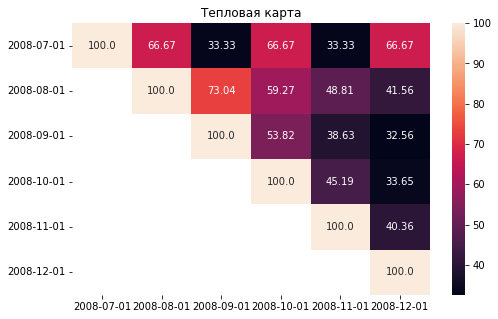

In [26]:
# тепловая карта Retention Rate
retention = table_8.pivot('cohort_dt', 'session_dt', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]


plt.figure(figsize=(8, 5)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта') 
plt.show() 

Июльская когорта: Retention Rate возрастает в октябре и декабре - такого быть не должно, так как уровень удержания клиентов всегда должен снижаться со временем, к тому же сами значения странные - повторяющиеся поочередно (66,67 и 33,33). Подозрительные значения Retention Rate указывают на ошибки в учёте количества пользователей по данной когорте;

В когорте пользователей, пришедших в августе, самое высокое значение Retention Rate за первый месяц, возможно в этот месяц запускали какую-то уникальную потрясающую акцию.

### Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

In [27]:
query = '''
WITH posts_month AS (
      SELECT EXTRACT (MONTH FROM creation_date) AS creation_month,
             COUNT(id) AS posts_count
        FROM stackoverflow.posts 
       WHERE creation_date :: date BETWEEN '2008-09-01' AND '2008-12-31'
    GROUP BY EXTRACT (MONTH FROM creation_date) 
    ORDER BY creation_month
)
                     
SELECT *,
       ROUND(( posts_count - LAG(posts_count) OVER () ) * 100 / LAG(posts_count) OVER () :: numeric, 2) AS percentage
  FROM posts_month
'''

table_9 = pd.read_sql_query(query, con = engine) 
table_9

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

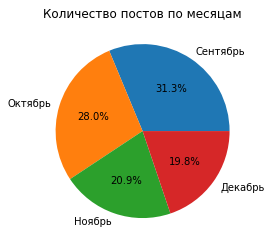

In [28]:
# круговая диаграммя с количеством постов по месяцам
labels = ['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
sizes = table_9['posts_count']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%.1f%%')
plt.title('Количество постов по месяцам')
plt.show()

### Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [29]:
query = '''
WITH week AS (   
      SELECT EXTRACT(WEEK FROM creation_date) week_creation,
             MAX(creation_date) OVER (ORDER BY EXTRACT(WEEK FROM creation_date)) creation_date
        FROM stackoverflow.posts 
       WHERE user_id = (
                 SELECT user_id
                   FROM stackoverflow.posts 
               GROUP BY user_id 
               ORDER BY COUNT(id) DESC
                  LIMIT 1
                     ) 
        AND creation_date :: date BETWEEN '2008-10-01' AND '2008-10-31'          
   ORDER BY creation_date
             )
   
  SELECT DISTINCT *
    FROM week
ORDER BY week_creation
'''

table_10 = pd.read_sql_query(query, con = engine) 
table_10

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


### Вывод
В ходе данной работы были выполнены запросы к базе данных StackOverFlow за 2008 год - сервиса вопросов и ответов о программировании. StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам.
 
- В сентябре 2008 года наблюдается резкий скачок количества просмотров, по сравнению с июлем и августом. Возможно это связано с началом учебного года, когда студенты начинают пользоваться сервисом или же началом какого-то нового интересного проекта. 
- Среди пользователей, которые в первый месяц после регистрации дали больше 100 ответов, каждому имени пользователя не обязательно соответствует только одно уникальное значений user_id. Скорее всего на данном сервисе иимя пользователя не обязательно должно быть уникальным.
- В августе 2008 года имеется 32 поста, которые создали пользователи, зарегестрировавшиеся в сентябре 2008 года, что по логике вещей, они не могли сделать, так как еще не были зарегестрированы. Странная аномалия, которая могла возникнуть может быть из-за разницы часовых поясов, например, кто-то опубликовал пост из другого часового пояса, где уже был сентябрь, а в системе сервиса еще был август.
- Выведено количество просмотров с накоплением для каждого пользователя, который написал пост.
- Найдено среднее количество постов пользователей в день за август 2008 года, для этого отобрали данные о пользователях, которые опубликовали больше 120 постов за август.
- Активные пользователи (которые хотя бы один пост за неделю выкладывают) взаимодействуют с платформой в среднем 2 дня из 7.
- Выведена история активности каждого пользователя с указанием даты предыдущего поста.
- Рассчитан аналог Retention Rate и построена тепловая карта: Июльская когорта: Retention Rate возрастает в октябре и декабре - такого быть не должно, так как уровень удержания клиентов всегда должен снижаться со временем, к тому же сами значения странные - повторяющиеся поочередно (66,67 и 33,33). Подозрительные значения Retention Rate указывают на ошибки в учёте количества пользователей по данной когорте; в когорте пользователей, пришедших в августе, самое высокое значение Retention Rate за первый месяц, возможно в этот месяц запускали какую-то уникальную потрясающую акцию.
- С сентября по декабрь 2008 года количество постов уменьшалось от месяца к месяцу. 
- Выгружены данные октябрьской активности пользователя, который опубликовал больше всего постов за все время.